In [1]:
# packages

import os
import numpy as np
import nibabel as nib
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_validate
from sklearn import svm
from sklearn.utils import shuffle
from tabulate import tabulate as tab
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 373 entries, 0 to 372
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Subject ID  373 non-null    object 
 1   MRI ID      373 non-null    object 
 2   Group       373 non-null    object 
 3   Visit       373 non-null    int64  
 4   MR Delay    373 non-null    int64  
 5   M/F         373 non-null    object 
 6   Hand        373 non-null    object 
 7   Age         373 non-null    int64  
 8   EDUC        373 non-null    int64  
 9   SES         354 non-null    float64
 10  MMSE        371 non-null    float64
 11  CDR         373 non-null    object 
 12  eTIV        373 non-null    int64  
 13  nWBV        373 non-null    object 
 14  ASF         373 non-null    object 
 15  Images      373 non-null    object 
dtypes: float64(2), int64(5), object(9)
memory usage: 46.8+ KB
None


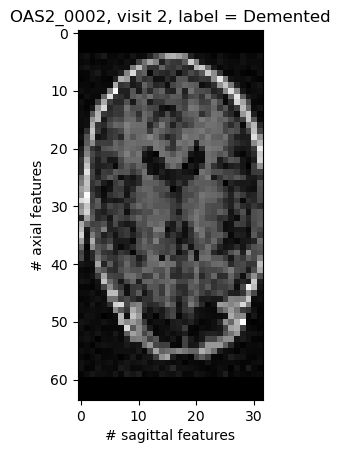

In [2]:
data = pd.read_pickle("Full_Image_data.pkl")

print(data.info())

# Check the image data
plt.imshow(data.iloc[3]['Images'][:, 40, :], cmap='gray')
plt.ylabel('# axial features')
plt.xlabel('# sagittal features')
plt.title(f"{data.iloc[3]['Subject ID']}, visit {data.iloc[3]['Visit']}, label = {data.iloc[3]['Group']}")
plt.show()

In [3]:
# Replace commas with dots before converting to float
data['nWBV'] = data['nWBV'].str.replace(',', '.').astype(float)
data['ASF'] = data['ASF'].str.replace(',', '.').astype(float)
data['CDR'] = data['CDR'].str.replace(',', '.').astype(float)


# Drop rows where MMSE is missing
data = data.dropna(subset=['MMSE'])

# Also drop rows where Images or Group are missing
data = data.dropna(subset=['Images', 'Group'])

# Reset index to align everything properly
data = data.reset_index(drop=True)


# Drop SES and Hand entirely
data = data.drop(columns=['SES'])
data = data.drop(columns=['Hand'])

# Encode categorical
data['M/F'] = data['M/F'].map({'M': 0, 'F': 1})

# Map all possible classes (update as needed)
group_map = {'Nondemented': 0, 'Demented': 1, 'Converted': 2}
data['Group'] = data['Group'].map(group_map)

print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 371 entries, 0 to 370
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Subject ID  371 non-null    object 
 1   MRI ID      371 non-null    object 
 2   Group       371 non-null    int64  
 3   Visit       371 non-null    int64  
 4   MR Delay    371 non-null    int64  
 5   M/F         371 non-null    int64  
 6   Age         371 non-null    int64  
 7   EDUC        371 non-null    int64  
 8   MMSE        371 non-null    float64
 9   CDR         371 non-null    float64
 10  eTIV        371 non-null    int64  
 11  nWBV        371 non-null    float64
 12  ASF         371 non-null    float64
 13  Images      371 non-null    object 
dtypes: float64(4), int64(7), object(3)
memory usage: 40.7+ KB
None


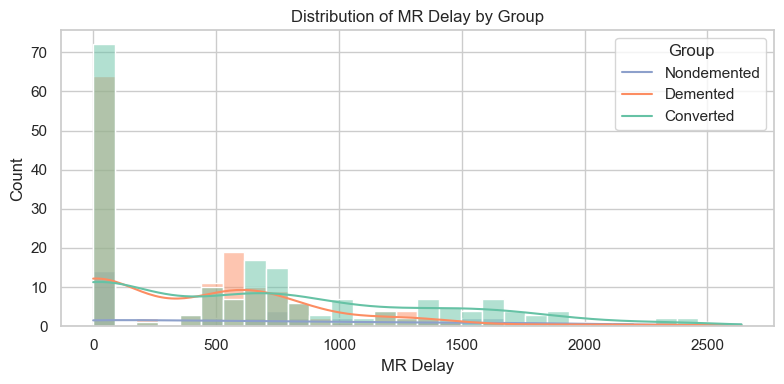

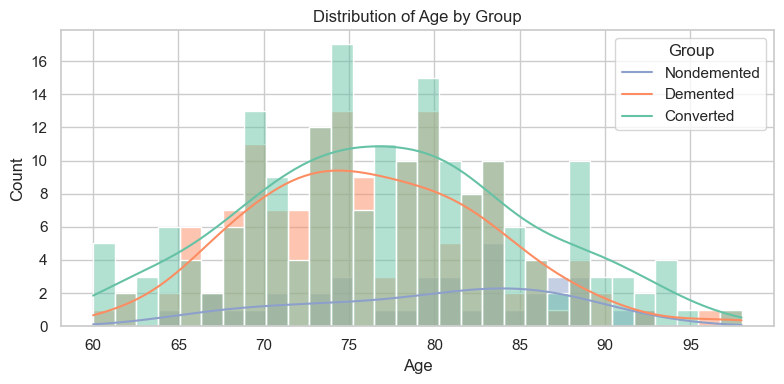

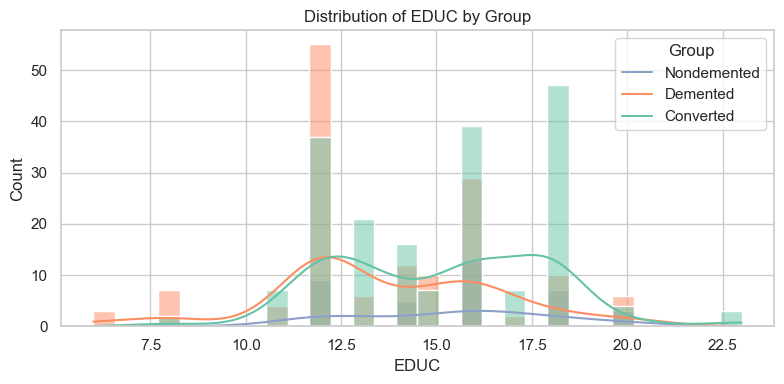

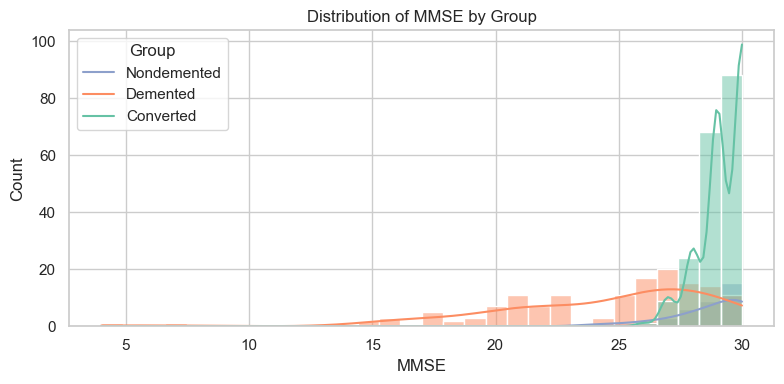

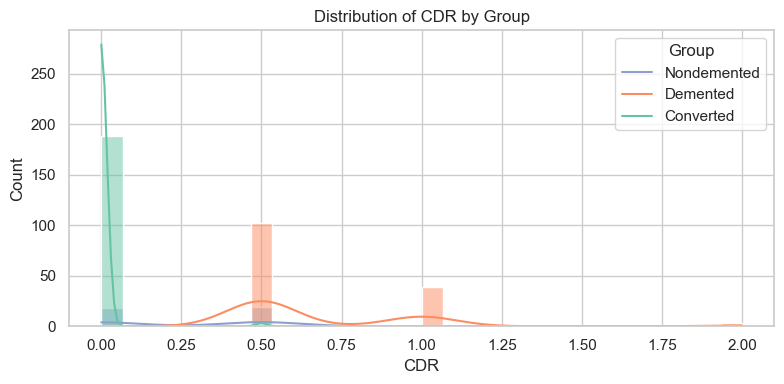

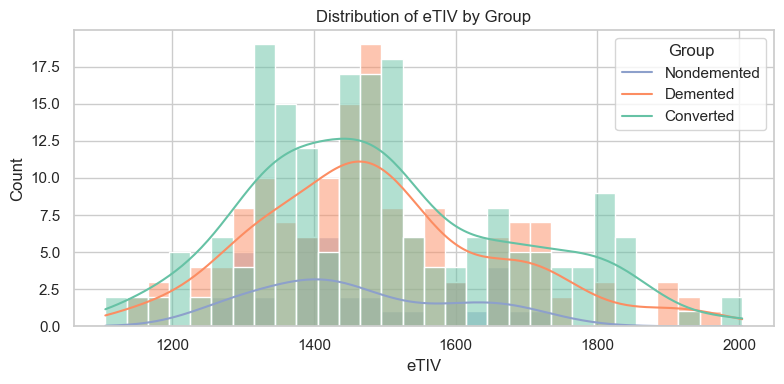

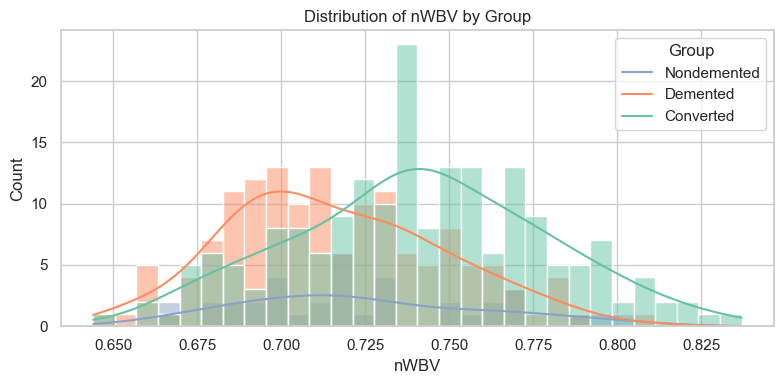

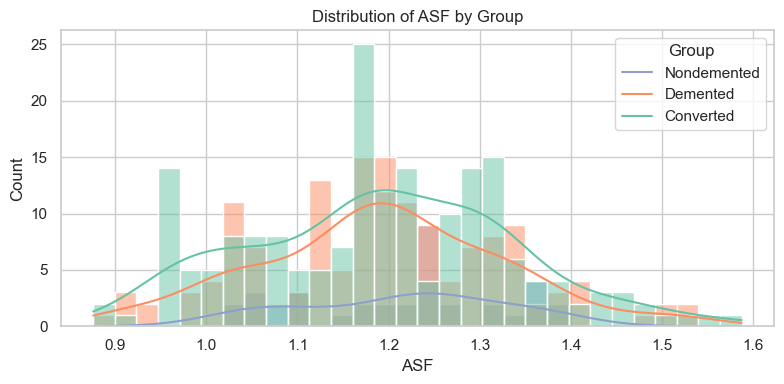

In [4]:
# Set seaborn theme
sns.set(style="whitegrid")

# List of numeric columns to plot
numeric_cols = ['MR Delay', 'Age', 'EDUC', 'MMSE', 'CDR', 'eTIV', 'nWBV', 'ASF']

# Plot each column distribution colored by group
for col in numeric_cols:
    plt.figure(figsize=(8, 4))
    sns.histplot(data, x=col, hue='Group', kde=True, bins=30, palette='Set2')
    plt.title(f'Distribution of {col} by Group')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.legend(title='Group', labels=['Nondemented', 'Demented', 'Converted'])
    plt.tight_layout()
    plt.show()

/var/folders/zl/6_fzmlzj5z5dbnsw61pkx2000000gn/T/ipykernel_14609/4043778131.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x='Group', palette='viridis', legend=False)


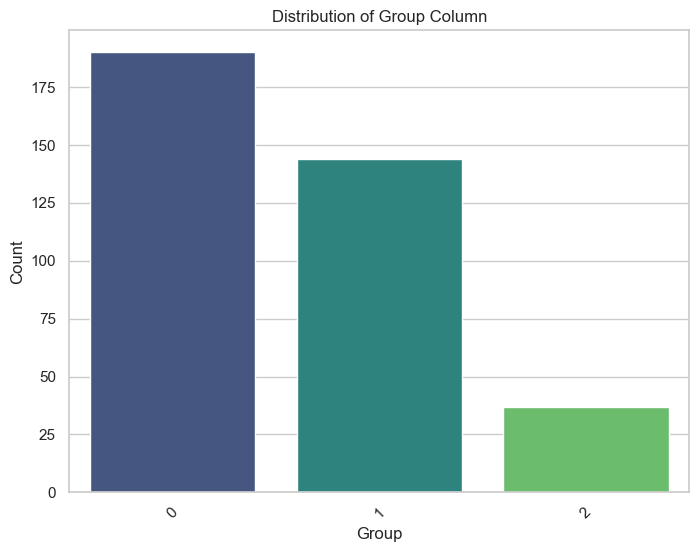

In [5]:
group_counts = data['Group'].value_counts()

# Alternatively, using seaborn for a count plot
plt.figure(figsize=(8, 6))
sns.countplot(data=data, x='Group', palette='viridis', legend=False)
plt.title('Distribution of Group Column')
plt.xlabel('Group')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [4]:
########################
# Feature extraction
########################

# Exclude group 2 from the dataset
data = data[data['Group'] != 2]

# Reset the index after filtering
data = data.reset_index(drop=True)

# Flatten image data
data['Image_flat'] = data['Images'].apply(lambda img: img.reshape(-1))
# Expand the Image_flat column into multiple columns
image_flat_df = pd.DataFrame(data['Image_flat'].tolist(), index=data.index) 

# Drop the original Images column
data = data.drop(columns=['Images'])
data = data.drop(columns=['Subject ID', 'MRI ID'])

# X = data.drop(columns=['Group'])
X = image_flat_df
y = data['Group']

# Ensure all column names are strings
X.columns = X.columns.astype(str)

# Split the data into training and test sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Apply SMOTE to balance the training data
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

print(X.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 334 entries, 0 to 333
Columns: 131072 entries, 0 to 131071
dtypes: float64(131072)
memory usage: 334.0 MB
None


In [7]:
# Check the new dataset
print(f"Original dataset size: {X_train.shape[0]}")
print(f"Balanced dataset size: {X_train_balanced.shape[0]}")

Original dataset size: 267
Balanced dataset size: 304


# Without SMOTE

In [5]:
# Define pipelines for KNN and SVM
knn_pipeline = Pipeline([
    ('knn', KNeighborsClassifier())  # KNN classifier
])

svm_pipeline = Pipeline([
    ('svm', SVC())  # SVM classifier
])

# Define hyperparameter grids for GridSearchCV
knn_param_grid = {
    'knn__n_neighbors': [3, 5, 7, 9, 11, 15, 21],
    'knn__weights': ['uniform', 'distance'],
    'knn__metric': ['minkowski', 'euclidean', 'manhattan']
}

svm_param_grid = {
    'svm__C': [0.1, 1, 3, 5, 10, 50],
    'svm__kernel': ['rbf', 'linear', 'poly'],
    'svm__gamma': ['scale', 'auto']
}

# Define StratifiedKFold with 3 splits
stratified_kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Perform GridSearchCV for KNN with StratifiedKFold
knn_grid_search = GridSearchCV(
    knn_pipeline, knn_param_grid, cv=stratified_kfold, scoring='accuracy', n_jobs=3
)
knn_grid_search.fit(X_train, y_train)

# Perform GridSearchCV for SVM with StratifiedKFold
svm_grid_search = GridSearchCV(
    svm_pipeline, svm_param_grid, cv=stratified_kfold, scoring='accuracy', n_jobs=3
)
svm_grid_search.fit(X_train, y_train)

# Evaluate the best models on the training and test sets
print("Best KNN parameters:", knn_grid_search.best_params_)
print("Best KNN cross-validated accuracy:", knn_grid_search.best_score_)

# KNN Training and Test Classification Reports
y_train_pred_knn = knn_grid_search.best_estimator_.predict(X_train)
y_test_pred_knn = knn_grid_search.best_estimator_.predict(X_test)
print("KNN Training Set Classification Report:\n", classification_report(y_train, y_train_pred_knn))
print("KNN Test Set Classification Report:\n", classification_report(y_test, y_test_pred_knn))

print("Best SVM parameters:", svm_grid_search.best_params_)
print("Best SVM cross-validated accuracy:", svm_grid_search.best_score_)

# SVM Training and Test Classification Reports
y_train_pred_svm = svm_grid_search.best_estimator_.predict(X_train)
y_test_pred_svm = svm_grid_search.best_estimator_.predict(X_test)
print("SVM Training Set Classification Report:\n", classification_report(y_train, y_train_pred_svm))
print("SVM Test Set Classification Report:\n", classification_report(y_test, y_test_pred_svm))

Best KNN parameters: {'knn__metric': 'manhattan', 'knn__n_neighbors': 15, 'knn__weights': 'uniform'}
Best KNN cross-validated accuracy: 0.6479400749063671
KNN Training Set Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.78      0.72       152
           1       0.63      0.49      0.55       115

    accuracy                           0.66       267
   macro avg       0.65      0.63      0.64       267
weighted avg       0.65      0.66      0.65       267

KNN Test Set Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.84      0.71        38
           1       0.60      0.31      0.41        29

    accuracy                           0.61        67
   macro avg       0.61      0.58      0.56        67
weighted avg       0.61      0.61      0.58        67

Best SVM parameters: {'svm__C': 10, 'svm__gamma': 'scale', 'svm__kernel': 'poly'}
Best SVM cross-validated accura

# With SMOTE

In [8]:
# Define pipelines for KNN and SVM with SMOTE
knn_pipeline = ImbPipeline([
    ('knn', KNeighborsClassifier())    # KNN classifier
])

svm_pipeline = ImbPipeline([
    ('svm', SVC())                      # SVM classifier
])

# Define hyperparameter grids for GridSearchCV
knn_param_grid = {
    'knn__n_neighbors': [3, 5, 7, 9, 11, 15, 21],
    'knn__weights': ['uniform', 'distance'],
    'knn__metric': ['minkowski', 'euclidean', 'manhattan']
}

svm_param_grid = {
    'svm__C': [0.1, 1, 3, 5, 10, 50],
    'svm__kernel': ['rbf', 'linear', 'poly'],
    'svm__gamma': ['scale', 'auto']
}

# Define StratifiedKFold with 3 splits
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform GridSearchCV for KNN with StratifiedKFold
knn_grid_search = GridSearchCV(
    knn_pipeline, knn_param_grid, cv=stratified_kfold, scoring='accuracy', n_jobs=2, verbose=3
)
knn_grid_search.fit(X_train_balanced, y_train_balanced)

# Perform GridSearchCV for SVM with StratifiedKFold
svm_grid_search = GridSearchCV(
    svm_pipeline, svm_param_grid, cv=stratified_kfold, scoring='accuracy', n_jobs=2, verbose=3
)
svm_grid_search.fit(X_train_balanced, y_train_balanced)

# Evaluate the best models on the training and test sets
print("Best KNN parameters:", knn_grid_search.best_params_)
print("Best KNN cross-validated accuracy:", knn_grid_search.best_score_)

# KNN Training and Test Classification Reports
y_train_pred_knn = knn_grid_search.best_estimator_.predict(X_train_balanced)
y_test_pred_knn = knn_grid_search.best_estimator_.predict(X_test)
print("KNN Training Set Classification Report:\n", classification_report(y_train_balanced, y_train_pred_knn))
print("KNN Test Set Classification Report:\n", classification_report(y_test, y_test_pred_knn))

print("Best SVM parameters:", svm_grid_search.best_params_)
print("Best SVM cross-validated accuracy:", svm_grid_search.best_score_)

# SVM Training and Test Classification Reports
y_train_pred_svm = svm_grid_search.best_estimator_.predict(X_train_balanced)
y_test_pred_svm = svm_grid_search.best_estimator_.predict(X_test)
print("SVM Training Set Classification Report:\n", classification_report(y_train_balanced, y_train_pred_svm))
print("SVM Test Set Classification Report:\n", classification_report(y_test, y_test_pred_svm))

Fitting 5 folds for each of 42 candidates, totalling 210 fits
[CV 1/5] END knn__metric=minkowski, knn__n_neighbors=3, knn__weights=uniform;, score=0.557 total time=   6.1s
[CV 2/5] END knn__metric=minkowski, knn__n_neighbors=3, knn__weights=uniform;, score=0.541 total time=   5.4s
[CV 3/5] END knn__metric=minkowski, knn__n_neighbors=3, knn__weights=uniform;, score=0.623 total time=   5.1s
[CV 4/5] END knn__metric=minkowski, knn__n_neighbors=3, knn__weights=uniform;, score=0.590 total time=   5.6s
[CV 5/5] END knn__metric=minkowski, knn__n_neighbors=3, knn__weights=uniform;, score=0.600 total time=   5.0s
[CV 1/5] END knn__metric=minkowski, knn__n_neighbors=3, knn__weights=distance;, score=0.557 total time=   5.1s
[CV 2/5] END knn__metric=minkowski, knn__n_neighbors=3, knn__weights=distance;, score=0.541 total time=   6.1s
[CV 3/5] END knn__metric=minkowski, knn__n_neighbors=3, knn__weights=distance;, score=0.623 total time=   5.4s
[CV 4/5] END knn__metric=minkowski, knn__n_neighbors=3,